<a href="https://colab.research.google.com/github/zoltan23/Audio-Classification/blob/master/spectrograms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install python_speech_features
!git clone https://github.com/seth814/Audio-Classification.git
!mkdir Audio-Classification/clean
!mkdir Audio-Classification/samples
!mkdir Audio-Classification/models
!mkdir Audio-Classification/pickles

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp36-none-any.whl size=5889 sha256=06651ab733a934e043b5ab6151e7afb3609f3da2422905d276af58c342cf8ccd
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features
Cloning into 'Audio-Classification'...
remote: Enumerating objects: 328, done.
remote: Total 328 (delta 0), reused 0 (delta 0), pack-reused 328
Receiving objects: 100% (328/328), 94.87 MiB | 28.38 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Checking out files: 100% (307/307), done.


Using TensorFlow backend.


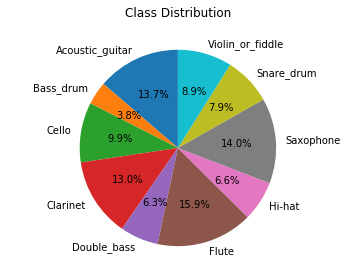

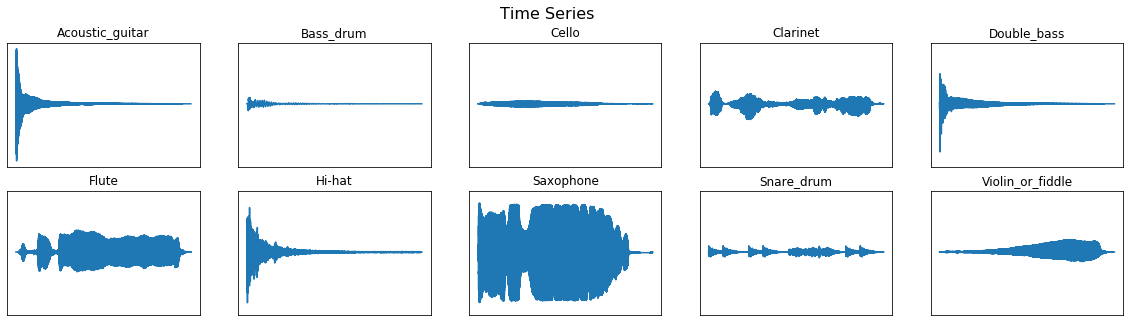

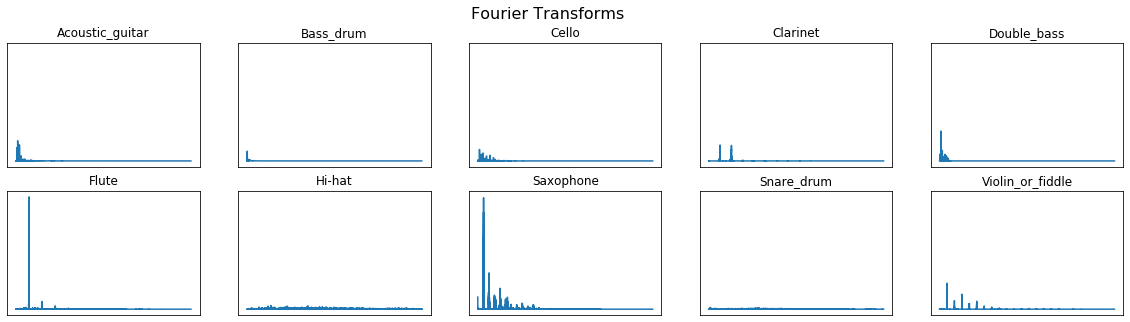

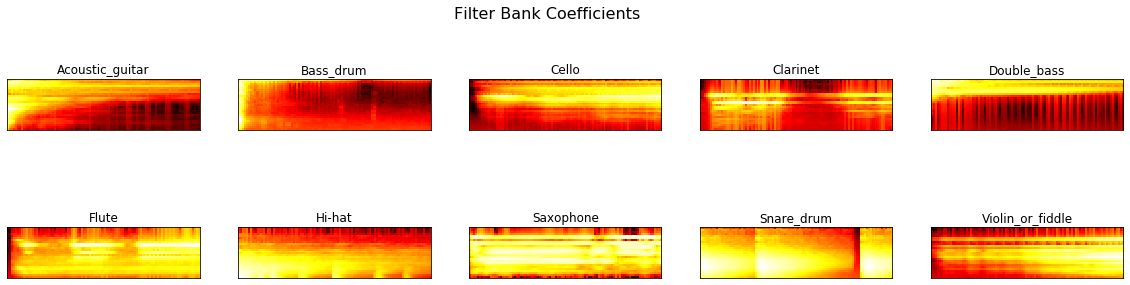

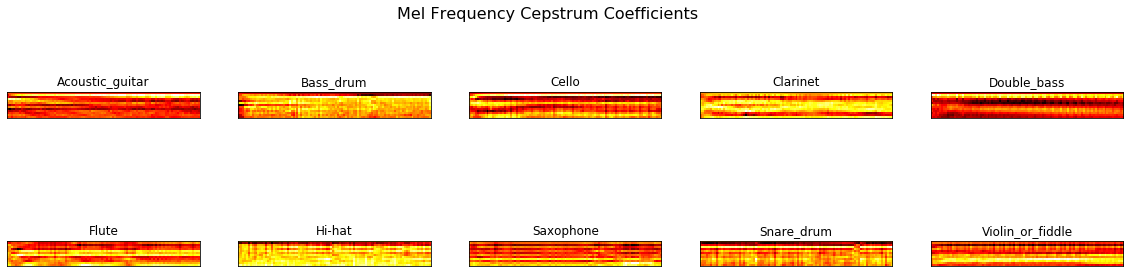

100%|██████████| 300/300 [01:53<00:00,  2.79it/s]


In [ ]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc, logfbank
import librosa

def plot_signals(signals):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_fft(fft):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq, Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1
            
def envelope(y, rate, threshold):
  mask = []
  y = pd.Series(y).apply(np.abs)
  y_mean = y.rolling(window=int(rate/10), min_periods=1, center=True).mean()
  for mean in y_mean:
    if mean > threshold:
      mask.append(True)
    else:
      mask.append(False)
  return mask
     

def calc_fft(y, rate):
  n = len(y)
  freq = np.fft.rfftfreq(n, d=1/rate)
  Y = abs(np.fft.rfft(y)/n)
  return (Y, freq)
            
df = pd.read_csv('Audio-Classification/instruments.csv')
df.set_index('fname', inplace=True)


for f in df.index:
  rate, signal = wavfile.read('Audio-Classification/wavfiles/' +f)
  df.at[f, 'length'] = signal.shape[0]/rate
  
  

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()
  
  
fig, ax =plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
      shadow=False, startangle=90)
ax.axis('equal')
plt.show()
df.reset_index(inplace=True)

#dictionaries
signals = {}
fft = {}
fbank = {}
mfccs = {}

for c in classes:
  wav_file = df[df.label == c].iloc[0,0]
  signal, rate = librosa.load('Audio-Classification/wavfiles/' + wav_file, sr=44100)
  mask = envelope(signal, rate, 0.0005)
  signal = signal[mask]
  signals[c] = signal
  fft[c] = calc_fft(signal, rate)
  
  bank = logfbank(signal[:rate], rate, nfilt = 26, nfft = 1103).T
  #filter bank
  fbank[c] = bank
  mel = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft= 1103).T
  mfccs[c] = mel
                    
plot_signals(signals)
plt.show()
                    
plot_fft(fft)
plt.show()

plot_fbank(fbank)
plt.show()                    

plot_mfccs(mfccs)
plt.show() 


if(len(os.listdir('Audio-Classification/clean/')) == 0):
  for f in tqdm(df.fname):
    signal, rate = librosa.load('Audio-Classification/wavfiles/' +f, sr=16000)
    mask = envelope(signal, rate, 0.0005)
    wavfile.write(filename='Audio-Classification/clean/' +f, rate=rate, data=signal[mask])

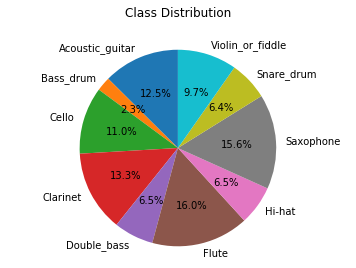

100%|██████████| 26410/26410 [01:23<00:00, 317.81it/s]


In [ ]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc, logfbank
import librosa

def build_rand_feat():
  X = []
  y = []
  _min, _max = float('inf'), -float('inf')
  for _ in tqdm(range(n_samples)):
    rand_class = np.random.choice(class_dist.index, p=prob_dist)
    file = np.random.choice(df[df.label==rand_class].index)
    rate, wav = wavfile.read('Audio-Classification/clean/'+f)
    label = df.at[file, 'label']
    rand_index = np.random.randint(0, wav.shape[0]-config.step)
    sample = wav[rand_index:rand_index+config.step]
    X_sample = mfcc(sample, rate, numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft)
    _min = min(np.amin(X_sample), _min)
    _max = min(np.amax(X_sample), _max)
    X.append(X_sample if config.mode == 'conv' else  X_sample.T)
    y.append(classes.index(label))
  X, y = np.array(X), np.array(y)
  X = (X - _min) / (_max - _min)
  if config.mode == 'conv':
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
  elif config.mode == 'time':
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
  y = to_categorical(y, num_classes=10)
  return X, y  

class Config:
  #nfft=512
  def __init__(self, mode='conv', nfilt=26, nfeat=13, nfft=1104, rate=16000):
    self.mode = mode
    self.nfilt = nfilt
    self.nfeat = nfeat
    self.nfft = nfft
    self.rate = rate
    self.step = int(rate/10)

df = pd.read_csv('Audio-Classification/instruments.csv')
df.set_index('fname', inplace=True)

for f in df.index:
  rate, signal = wavfile.read('Audio-Classification/clean/'+f)
  df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

n_samples = 2 * int(df['length'].sum()/0.1)
prob_dist = class_dist / class_dist.sum()
#Random sampling from audio data
choices = np.random.choice(class_dist.index, p=prob_dist)

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

config = Config(mode='conv')

if config.mode == 'conv':
  X, y = build_rand_feat()
  
elif config.mode == 'time':
  X, y = build_rand_feat()


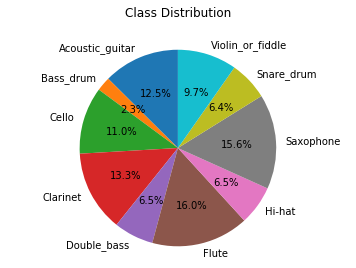

100%|██████████| 26410/26410 [01:23<00:00, 318.04it/s]


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 9, 13, 16)         160       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 9, 13, 32)         4640      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 9, 13, 64)         18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 9, 13, 128)        73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 6, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 6, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3072)             

In [ ]:

import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc
import librosa

def build_rand_feat():
  X = []
  y = []
  _min, _max = float('inf'), -float('inf')
  for _ in tqdm(range(n_samples)):
    rand_class = np.random.choice(class_dist.index, p=prob_dist)
    file = np.random.choice(df[df.label==rand_class].index)
    rate, wav = wavfile.read('Audio-Classification/clean/'+f)
    label = df.at[file, 'label']
    rand_index = np.random.randint(0, wav.shape[0]-config.step)
    sample = wav[rand_index:rand_index+config.step]
    X_sample = mfcc(sample, rate, numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft)
    _min = min(np.amin(X_sample), _min)
    _max = min(np.amax(X_sample), _max)
    X.append(X_sample if config.mode == 'conv' else  X_sample.T)
    y.append(classes.index(label))
  X, y = np.array(X), np.array(y)
  X = (X - _min) / (_max - _min)
  if config.mode == 'conv':
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
  elif config.mode == 'time':
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
  y = to_categorical(y, num_classes=10)
  return X, y
    
    
def get_conv_model():
  model = Sequential()
  model.add(Conv2D(16, (3,3), activation='relu', strides=(1,1), padding='same', input_shape=input_shape))
  model.add(Conv2D(32, (3,3), activation='relu', strides=(1,1), padding="same"))
  model.add(Conv2D(64, (3,3), activation='relu', strides=(1,1), padding="same"))
  model.add(Conv2D(128, (3,3), activation='relu', strides=(1,1), padding="same"))
  model.add(MaxPool2D((2,2)))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  model.summary()
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
  
  return model
  

class Config:
    def __init__(self, mode='conv', nfilt=26, nfeat=13, nfft=1104, rate=16000):
      self.mode = mode
      self.nfilt = nfilt
      self.nfeat = nfeat
      self.nfft = nfft
      self.rate = rate
      self.step = int(rate/10)

df = pd.read_csv('Audio-Classification/instruments.csv')
df.set_index('fname', inplace=True)

for f in df.index:
    rate, signal = wavfile.read('Audio-Classification/clean/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

n_samples =2 * int(df['length'].sum()/0.1)
prob_dist = class_dist / class_dist.sum()
choices = np.random.choice(class_dist.index, p=prob_dist)

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

config = Config(mode='conv')

if config.mode == 'conv':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2], 1)
    model = get_conv_model()
  
elif config.mode == 'time':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2])
    model = get_recurrent_model()
    
class_weight = compute_class_weight('balanced', 
                                     np.unique(y_flat),
                                     y_flat)

model.fit(X, y, epochs=10, batch_size=32, shuffle=True, class_weight=class_weight)

In [ ]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc
import pickle
from keras.callbacks import ModelCheckpoint
import librosa

def check_data():
  if os.path.isfile(config.p_path):
    print("Loading existing data for {} model" .format(config.mode))
    with open(config.p_path, 'rb') as handle:
      tmp = pickle.load(handle)
      return tmp
  else:
    return None

def build_rand_feat():
  tmp = check_data()
  if tmp:
    return tmp.data[0], tmp.data[1]
  X = []
  y = []
  _min, _max = float('inf'), -float('inf')
  for _ in tqdm(range(n_samples)):
    rand_class = np.random.choice(class_dist.index, p=prob_dist)
    file = np.random.choice(df[df.label==rand_class].index)
    rate, wav = wavfile.read('Audio-Classification/wavfiles/'+f)
    label = df.at[file, 'label']
    rand_index = np.random.randint(0, wav.shape[0]-config.step)
    sample = wav[rand_index:rand_index+config.step]
    X_sample = mfcc(sample, rate, numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft)
    _min = min(np.amin(X_sample), _min)
    _max = min(np.amax(X_sample), _max)
    X.append(X_sample)
    y.append(classes.index(label))
  config.min = _min
  config.max = _max
  X, y = np.array(X), np.array(y)
  X = (X - _min) / (_max - _min)
  if config.mode == 'conv':
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
  elif config.mode == 'time':
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
  y = to_categorical(y, num_classes=10)
  config.data = (X, y)
  
  with open(config.p_path, 'wb') as handle:
    pickle.dump(config, handle, protocol=2)
    
  return X, y
    
    
def get_conv_model():
  model = Sequential()
  model.add(Conv2D(16, (3,3), activation='relu', strides=(1,1), padding='same', input_shape=input_shape))
  model.add(Conv2D(32, (3,3), activation='relu', strides=(1,1), padding="same"))
  model.add(Conv2D(64, (3,3), activation='relu', strides=(1,1), padding="same"))
  model.add(Conv2D(128, (3,3), activation='relu', strides=(1,1), padding="same"))
  model.add(MaxPool2D((2,2)))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  model.summary()
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
  
  return model

class Config:
    def __init__(self, mode='conv', nfilt=26, nfeat=13, nfft=1104, rate=16000):
      self.mode = mode
      self.nfilt = nfilt
      self.nfeat = nfeat
      self.nfft = nfft
      self.rate = rate
      self.step = int(rate/10)
      self.model_path = os.path.join('Audio-Classification/models', mode + '.model')
      self.p_path = os.path.join('Audio-Classification/pickles', mode + '.p')

  

df = pd.read_csv('Audio-Classification/instruments.csv')
df.set_index('fname', inplace=True)

for f in df.index:
    rate, signal = wavfile.read('Audio-Classification/clean/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

n_samples =2 * int(df['length'].sum()/0.1)
prob_dist = class_dist / class_dist.sum()
choices = np.random.choice(class_dist.index, p=prob_dist)

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

config = Config(mode='conv')

if config.mode == 'conv':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2], 1)
    model = get_conv_model()
  
elif config.mode == 'time':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2])  
    model = get_recurrent_model()
    
class_weight = compute_class_weight('balanced', 
                                     np.unique(y_flat),
                                     y_flat)

checkpoint = ModelCheckpoint(config.model_path, monitor='val_acc', verbose=1, mode='max',
                            save_best_only=True, save_weights_only=False, period=1)

model.fit(X, y, epochs=10, batch_size=32, shuffle=True, validation_split=0.1, callbacks=[checkpoint])

model.save(config.model_path)




In [ ]:
import pickle
import os
import numpy as np
from tqdm import tqdm
from scipy.io import wavfile
from python_speech_features import mfcc
from keras.models import load_model
import pandas as pd
from sklearn.metrics import accuracy_score


def build_predictions(audio_dir):
  y_true = []
  y_pred = []
  fn_prob = {}
  
  print('Extracting features from audio')
  for fn in tqdm(os.listdir(audio_dir)):
    rate, wav = wavfile.read(os.path.join(audio_dir, fn))
    label = fn2class[fn]
    c = classes.index(label)
    y_prob = []
    
    for i in range(0, wav.shape[0]-config.step, config.step):
      sample = wav[i:i+config.step]
      x = mfcc(sample, rate, numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft)
      x = (x - config.min) / (config.max - config.min)      
      
      if config.mode == 'conv':
        x = x.reshape(1, x.shape[0], x.shape[1], 1)
      elif config.mode == 'time':
        x = np.expand_dims(x, axis=0)
      y_hat = model.predict(x)
      y_prob.append(y_hat)
      y_pred.append(np.argmax(y_hat))
      y_true.append(c)

    fn_prob[fn] = np.mean(y_prob, axis=0).flatten()
  
  return y_true, y_pred, fn_prob

  
  
df = pd.read_csv('Audio-Classification/instruments.csv')
classes = list(np.unique(df.label))
fn2class = dict(zip(df.fname, df.label))
p_path = os.path.join('Audio-Classification/pickles', 'conv.p')

with open(p_path, 'rb') as handle:
  config = pickle.load(handle)
  
 
  
  
model = load_model('Audio-Classification/models/conv.model')
print("model", model)

y_true, y_pred, fn_prob = build_predictions('Audio-Classification/clean')

acc_score = accuracy_score(y_true=y_true, y_pred=y_pred)

y_probs = []
for i, row in df.iterrows():
  y_prob = fn_prob[row, fname]
  y_probs.append(y_prob)
  for c, p in zip(classes, y_prob):
    df.at[i,c] = p
    
y_pred = [classes[np.argmax(y)] for y in y_probs]

df['y_pred'] = y_pred

df.to_csv('predictions.csv', index=False)
